# 61 — Deep Residual Learning in Spiking Neural Networks
By Fang, Wei, Zhaofei Yu, Yanqi Chen, Tiejun Huang, Timothée Masquelier, and Yonghong Tian. 2021. "Deep Residual Learning in Spiking Neural Networks." arXiv. https://arxiv.org/abs/2102.04159.


<h4>The goal of this notebook is to explain Spiking Neural Networks (SNNs) and how you can use residual learning to train deep SNNs.</h4>

We will begin by introducing SNNs, play with them to build a simple Fashion-MNIST classifier and explain how gradient learning works with SNNs.<br>Then we will implement ResNET, a deep convolutional network with SNNs, and see how we can train it.

You should <font color="crimson">use Google Colab <b>with a GPU</b></font> to run this notebook, unless you have Cupy, CUDA and a GPU with more than 14GB of VRAM if you want to train the ResNET implementation with SNNs.<br>Python 3.8 is highly recommended.

<font color='crimson'>This notebook should be played <b>in about an hour</b>. You should skip to the last section after 40 minutes.</font>
<br>The first parts are an introduction to SNNs and to building CNNs with them, you do not need to understand it all to understand the most important part, the Deep Residual Learning in SNNs part. Some parts are here as a bonus, feel free to skip them for now and go back to it later!


### Installation and library imports

<b>First let's install a library implementing SNNs in python</b>, the one used in the paper cited above.
<br>SpikingJelly documentation:
https://spikingjelly.readthedocs.io/zh_CN/0.0.0.0.12/#index-en 
<br>Some examples are adapted from this library

In [ ]:
# this is a library implementing SNNs in python. 
!pip install spikingjelly==0.0.0.0.12

In [ ]:
# install Cupy if you have CUDA (not needed in Colab)
# you should follow the tutorial https://docs.cupy.dev/en/stable/install.html
# to install with the precompiled wheels

# !pip install cupy-cuda12x # if you have cuda v12.x

In [ ]:
# Cupy is the computation backend used by spiking jelly. 
# It's like numpy but runs on GPUs. 
# The fallback backend for spiking jelly is torch. It's VERY slow for large SNNs
try: 
    import cupy
    snn_backend = "cupy"
except ImportError:
    snn_backend = "torch"
print("using spikingjelly backend:", snn_backend)

from pathlib import Path
import matplotlib.pyplot as plt
import os
import time
import argparse
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from spikingjelly.clock_driven import neuron, functional, surrogate, layer
from spikingjelly.clock_driven.functional import seq_to_ann_forward
from spikingjelly import visualizing

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"using device {DEVICE} for pytorch") # MPS is for macOS with ARM (apple silicon) processors

data_folder = Path("./data")


using spikingjelly backend: cupy
using device cuda for pytorch


## An introduction to Spiking Neural Networks, *SNNs* — 20 minutes

### A bit of theoric background

SNNs are different in many ways from ANNs which are fully-connected and use continuous values. Although ANNs are biologically inspired and helped us made breakthroughs, they are biologically inn-accurate and do not mimic our brains' neurons.
<br>
<br>
**Nature came up with SNNs**, a versatile solution to fault-tolerant and energy efficient signal processing in our brains.
Therefore, taking inspiration from the brain is a natural approach to engineering more efficient computing architectures.
<br>
<h3>How can we use SNNs to build neural networks? And what is a spiking neuron?</h3>

<a title="Harrypotterrrrr, CC BY-SA 4.0 &lt;https://creativecommons.org/licenses/by-sa/4.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Simplified_diagram_of_a_typical_biological_neural_cell_showing_a_basic_neuromorphic_unit_and_working_mechanism_diagram.png">
<img alt="Simplified diagram of a typical biological neural cell showing a basic neuromorphic unit and working mechanism diagram" src="https://upload.wikimedia.org/wikipedia/commons/5/58/Simplified_diagram_of_a_typical_biological_neural_cell_showing_a_basic_neuromorphic_unit_and_working_mechanism_diagram.png">
</a>

Here is a simplified diagram of a typical biological neural cell showing a basic neuromorphic unit and working mechanism diagram.
<br>
(A) Simplified diagram of a typical biological neural cell
<br>
(B) A spiking neural cell modeled as a basic neuromorphic unit.
<br><br>
(C) Working mechanism of a typical **integrate and fire neuron, which we will use in our SNNs**. Resistive synapses convert voltage spikes into currents proportional to their synaptic weights.
<br>
The neuron integrates these current inputs $V_{spk,in}$ injected by the previous neurons to change the membrane voltage $V_{mem}$. Once $V_{mem}$ crosses a firing threshold $V_{thr}$, the neuron fires and sends a spike $V_{spk}$ to the next neurons.

<h3>To sum up:</h3>

SNNs operate using spikes, which are discrete events that take place at points in time, rather than continuous values. The occurrence of a spike is determined by differential equations that represent various biological processes, the most important of which is the <b>membrane potential of the neuron</b>.

<h3>There are three equations to describe an Integrate and Fire (IF) neuron:</h3>

- <b>Membrane potential:</b>
<br>Leaky Integrate and Fire (LIF):
<br>$\frac{dV}{dt} = \frac{1}{\tau_m} * (-(V-V_{rest}) + R_m * I)$
<br>Where **$V$ is the membrane potential, $I$ is the input current**, ${\tau_m}$ is the membrane time constant, $V_{rest}$ is the resting potential, and $R_m$ is the membrane resistance.
<br><br>
If we take $R_m, {\tau_m} = 1$ and neglect the leaky part $V - V_{rest}$, **we have the Integrate and Fire neuron** (not leaky) described in the paper we're explaining in this notebook:
<br><b><font color="forestgreen">$V[t] = V[t-1] + I[t]$</font></b>
<br><br>
- <b>Output spike $S[t]$:</b>
<br>If the neuron's membrane potential is over the threshold, the neuron outputs a spike S.
<br>$S[t] = \Theta(V[t] - V_{th})$
<br>Where $\Theta$ is the Heaviside function: <font color="forestgreen">$S[t] = \begin{cases}
1 & \text{if } V[t] \geq V_{th} \\
0 & \text{otherwise}
\end{cases}$</font>
<br><br>
- <b>Resetting process</b>, also called hard reset in spikingjelly:
<br>When there is a spike, i.e. $S[t]=1$ the neuron's potential is reset to $V_{reset}$.
<br><font color="forestgreen">$V[t] = \begin{cases}
V_{reset} & \text{if } S[t] = 1 \\
V[t] & \text{if } S[t] = 0
\end{cases}$</font>


<img src="https://miro.medium.com/max/1100/1*vvjGQAfTlk2NPD7bmD1zVQ.gif" alt="leaky integrate and fire neuron"/>
<br>
Here is an animation of a Leaky IF's membrane potential behavior during a spike

<img src="https://github.com/arthurlaquieze/deep-residual-learning-SNN/blob/main/img/Potential%20of%20a%20LIF%20neuron.png?raw=1" width="600">
<br>From Neftci, E. O., Mostafa, H., & Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks: Bringing the Power of Gradient-based optimization to spiking neural networks. IEEE Signal Processing Magazine, 36, 51-63.


The image above shows <b>how a LIF neuron will output spikes</b> depending on its membrane potential, in purple, when exited by the four input neurons, in a time simulation.

Now that we know how a spiking neuron works, let's try using them!

### First steps with spiking neurons

We will use a Leaky Integrate and Fire neuron and play with its parameters.

LIFNode(
  v_threshold=1.0, v_reset=0.0, detach_reset=False, tau=30.0
  (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
)


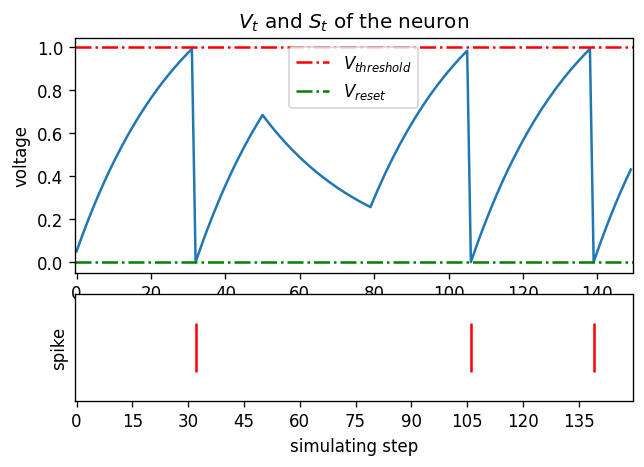

In [ ]:
lif_neuron = neuron.LIFNode(
    # Play with those parameters!
    tau=float(30.0), 
    v_reset=float(0.), 
    v_threshold=float(1.),
)

print(lif_neuron)
lif_neuron.reset() # reset potential

input_current = float(1.5)
x = torch.as_tensor([input_current])

no_input = torch.as_tensor([0])

T = 150
s_list = []
v_list = []
for t in range(T):
    # give no input current in the middle of the simulation steps
    if t > 50 and t < 80:
        s_list.append(lif_neuron(no_input))
        v_list.append(lif_neuron.v)
    
    # input current x during the rest of the simulation
    else:
        # when doing lif_neuron(x), the neuron sees an input current of x at this step
        s_list.append(lif_neuron(x))

        # lif_neuron.v is the neuron's membrane potential
        v_list.append(lif_neuron.v)

s_list = np.array([np.array(i) for i in s_list]).squeeze()
v_list = np.array([np.array(i) for i in v_list]).squeeze()

visualizing.plot_one_neuron_v_s(
    v_list,
    s_list,
    v_threshold=lif_neuron.v_threshold,
    v_reset=lif_neuron.v_reset,
    dpi=120,
)
plt.show()


What happens when you change the threshold or the input current?
<br>And what happens in the middle?

<details>
  <summary>
  <font color="forestgreen">Click to show/hide the answer</font>
  </summary>
  
  - When you decrease $\tau$ the neuron is faster, thus it will fire more spikes!

  - When you increase the input current the neuron gets exited faster and will also fire more spikes

  - In the middle the neuron is not exited. As it is leaky its membrane potential decreases over time / over the simulation steps.
</details>


<font color="crimson">You should skip to the next part (CNN with spiking layers) if you're more than 20 minutes in.</font>  

### Going further with spiking neurons — bonus

Can you <b>do the same thing for an IF neuron</b>, which is not leaky, and compare the results?
<br>Can you find an input current to have similar results?

In [ ]:
if_neuron = neuron.IFNode(v_reset=0., v_threshold=1.)
print(if_neuron)

if_neuron.reset() # reset membrane potential

# put your input current here
input_current = float(??)

x = torch.as_tensor([input_current])

no_input = torch.as_tensor([0])

T = 150
s_list = []
v_list = []
for t in range(T):
    if t > 50 and t < 80:
        s_list.append(if_neuron(no_input))
        v_list.append(if_neuron.v)
    else:
        s_list.append(if_neuron(x))
        v_list.append(if_neuron.v)

s_list = np.array([np.array(i) for i in s_list]).squeeze()
v_list = np.array([np.array(i) for i in v_list]).squeeze()

visualizing.plot_one_neuron_v_s(
    v_list,
    s_list,
    v_threshold=if_neuron.v_threshold,
    v_reset=if_neuron.v_reset,
    dpi=120,
)
plt.show()


<details>
  <summary>
  <font color="forestgreen">Click to show/hide the answer</font>
  </summary>

As this neuron is not leaky, with an input current over the threshold, you guessed it, it would always fire.
<br>An input current of 0.1 is a good choice.
</details>

Bellow you can visualize multiple neurons potentials when the input current is different for each. 
<br>


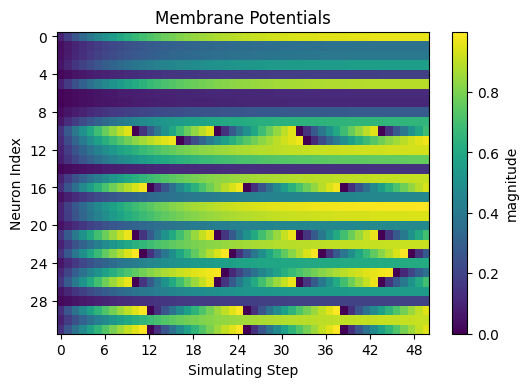

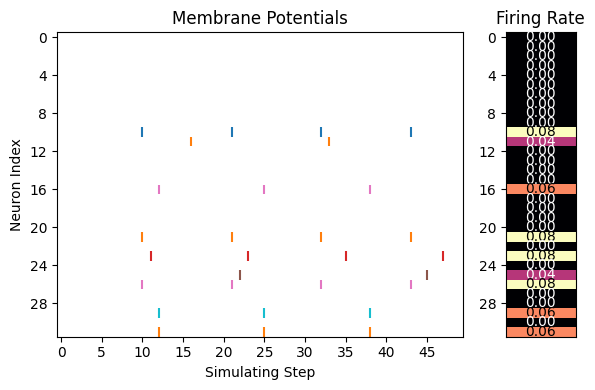

In [ ]:
lif = neuron.LIFNode(tau=10.)

lif.reset()

# the input current is rand(0, 1) * 1.5 for each of the 32 neurons
x = torch.rand(size=[32]) * 1.5
T = 50
s_list = []
v_list = []
for t in range(T):
    s_list.append(lif(x).unsqueeze(0))
    v_list.append(lif.v.unsqueeze(0))

s_list = torch.cat(s_list)
v_list = torch.cat(v_list)

visualizing.plot_2d_heatmap(array=np.asarray(v_list), title='Membrane Potentials', xlabel='Simulating Step',
                            ylabel='Neuron Index', int_x_ticks=True, x_max=T, dpi=100)
visualizing.plot_1d_spikes(spikes=np.asarray(s_list), title='Membrane Potentials', xlabel='Simulating Step',
                           ylabel='Neuron Index', dpi=100)
plt.show()


<b>Great, now we know what spiking neurons are, and we've played with them!</b>
<br>
At this point you should be wondering what's their use in neural networks, and how can we use them instead of fully-connected ANN layers?
<br><br>
Let's dive in and see how we can apply them to image classification.

## Use of SNN in convolutional neural networks to identify Fashion-MNIST — 20 minutes

Before diving into the deep residual learning with the complicated and heavy ResNET, **let's implement a simple CNN with SNN layers** for image classification, to understand how SNNs work and **especially understand how gradient learning works with spiking neurons**. 

### Model definition and training

In [ ]:
# let's load the Fashion-MNIST dataset
# This one is harder than the MNIST dataset of handwritten number, so the challenge is bigger :)

# Define the transform to normalize the data
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.5,), (0.5,))])

# Load the train dataset 
trainset = torchvision.datasets.FashionMNIST(root=data_folder, train=True, download=True, transform=transform)
train_data_loader_fashion = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the test dataset
testset = torchvision.datasets.FashionMNIST(root=data_folder, train=False, download=True, transform=transform)
test_data_loader_fashion = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


<font color="crimson">You should launch the training by running the cells bellow when you read this, as training takes 5 to 10 minutes</font>


This model is s a spiking neural network that consists of a static convolutional layer followed by multiple convolutional and IFNode layers.
<br><b>The network uses IFNode layers, which replace the typical ReLU</b> activation in a traditional convolutional neural network. It runs a multi-step time simulation on the conv and fc layers containing IFNodes.
<br>Have a look at the comments for more details.

In [ ]:
# this implementation is slower than with cupy on CUDA, but simpler to understand!
# Have a look at this one, and then check the CupyNet that uses layers that can be ran with Cupy on Cuda.

class PythonNet(nn.Module):
    def __init__(self, T, surrogate_func = surrogate.ATan):
        super().__init__()

        # T is the number of simulation steps. We will use 4 by default
        # In the introduction above we used 150 time steps, but 
        # only 4 are needed here to have good results.
        self.T = T

        # here we have 28*28 images in input with 1 channel
        self.static_conv = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )

        self.conv = nn.Sequential(
            # The IFNode is our SNN layer that replaces the ReLU that would be here in a normal CNN.
            # 
            # We will talk about the surrogate_function later!
            # can you guess what is it here for? 
            # you can try other ones, like surrogate.Sigmoid()
            # Hint: it's about back-propagation, as spikes, built with the 
            # Heaviside function, do not have a proper gradient.
            neuron.IFNode(surrogate_function=surrogate_func(),),
            nn.MaxPool2d(2, 2),  # outputs a 14 * 14 image size, with 128 channels

            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),

            neuron.IFNode(surrogate_function=surrogate_func()),
            nn.MaxPool2d(2, 2)  # 7 * 7 image size, with 128 channels

        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128 * 4 * 4, bias=False),
            neuron.IFNode(surrogate_function=surrogate_func()),
            nn.Linear(128 * 4 * 4, 10, bias=False),

            # last layer is a spiking IF neurons node
            neuron.IFNode(surrogate_function=surrogate_func()),
        )


    def forward(self, x):
        x = self.static_conv(x)

        # here is the multi step time simulation of the SNN layers
        #
        # The image resulting from the static_conv in the input of the conv layer
        # is static, so we send the same x to the conv layer over the simulation steps.
        #
        # Thus for each time step we run the conv and fc containing neuron.IFNode and some Conv2D, etc., 
        # each time with the same parameters. 
        # The temporal aspect will be kept in the neurons' membrane protentials!
        #
        # As the neurons in the IFNode layers keep their membrane potential between two time steps,
        # we can do this loop over T time steps as we did before with just one neuron!
        out_spikes_counter = self.fc(self.conv(x))
        for t in range(1, self.T):
            out_spikes_counter += self.fc(self.conv(x))

        # we return the mean of the spiking output layer over the simulation period, you'll see why too!
        # But in short, that's how the IFNode layer encodes information:
        # over just one time step it would only be 0s and 1s.. 
        return out_spikes_counter / self.T

In [ ]:
# this network is the same as PythonNet, but it can be ran with Cupy and CUDA to be a lot faster.
# Have a look at this, we replaced the IFNodes by MultiStepIFNodes that implement the simulation loop
# over T steps in Cupy. This way we no longer need the loop over T steps in the forward function.

class CupyNet(nn.Module):
    def __init__(self, T):
        super().__init__()

        # T is the number of simulation steps. We will use 4 by default
        self.T = T

        self.static_conv = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
        )

        self.conv = nn.Sequential(
            # our SNN layer that replaces the ReLU that would be here in a normal CNN
            # we will talk about the surrogate_function later! 
            # you can try other ones, like surrogate.Sigmoid()
            #
            # The MultiStep is equivalent to doing the loop we did before during 150 steps on a single IFNode
            neuron.MultiStepIFNode(surrogate_function=surrogate.ATan(), backend=snn_backend),
            
            # this allows the contained ANN to handle sequential data: the IFNode output, that is of dim [T, batch_size, ...].
            layer.SeqToANNContainer(
                    nn.MaxPool2d(2, 2),  # 14 * 14
                    nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
                    nn.BatchNorm2d(128),
            ),
            neuron.MultiStepIFNode(surrogate_function=surrogate.ATan(), backend=snn_backend),
            layer.SeqToANNContainer(
                nn.MaxPool2d(2, 2),  # 7 * 7
                nn.Flatten(),
            ),
        )
        self.fc = nn.Sequential(
            layer.SeqToANNContainer(nn.Linear(128 * 7 * 7, 128 * 4 * 4, bias=False)),
            neuron.MultiStepIFNode(surrogate_function=surrogate.ATan(), backend=snn_backend),
            layer.SeqToANNContainer(nn.Linear(128 * 4 * 4, 10, bias=False)),
            neuron.MultiStepIFNode(surrogate_function=surrogate.ATan(), backend=snn_backend),
        )

    def forward(self, x):
        # [N_batch, Channels, Hight, Width] -> [1, N, C, H, W] -> [T, N, C, H, W]
        # 
        # this allows to pass x_seq to the MultiStepIFNode later: 
        # the input is an image and it is static, the MultiStepIFNode expects T inputs, one for each of the T time steps
        # Thus we need to send x_seq repeated T times to the MultiStepIFNode (first step of the self.conv layer).
        x_seq = self.static_conv(x).unsqueeze(0).repeat(self.T, 1, 1, 1, 1)

        # here we take the mean of the spiking output layer over the simulation steps
        # Again, this is how you can use the spiking output!
        return self.fc(self.conv(x_seq)).mean(0)

In [ ]:
# Let's do the training. It's pretty straightforward, but have a look at the comments.

num_epochs = 10
# keep this to 10 if you're launching this cell in advance, 
# else use 5. 
# On colab it will take about 6 min with 10 epochs and 3 minutes with 5 epochs (accuracy should be over 90% anyway).

net = CupyNet(T=4) # you can try different simulation steps!
net = net.to(DEVICE)
print(f"training with pytorch on {DEVICE} with spikingjelly backend being {snn_backend}")

cupynet_cpt_dir = Path("./checkpoints/checkpointCupyNet.pt")
os.makedirs(cupynet_cpt_dir.parent, exist_ok=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=64)

max_test_acc = 0
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    net.train()

    train_loss = 0
    train_acc = 0
    train_samples = 0
    for frame, label in train_data_loader_fashion:
        optimizer.zero_grad()
        frame = frame.float().to(DEVICE)
        label = label.to(DEVICE)
        label_onehot = F.one_hot(label, 10).float()

        out_fr = net(frame)
        loss = F.mse_loss(out_fr, label_onehot)
        loss.backward()
        optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        # the predicted label is out_fr.argmax(1)
        # out_fr size is [batch_size, 10] as their are 10 classes
        train_acc += (out_fr.argmax(1) == label).float().sum().item()

        # It's very important to reset the membrane potentials of the neurones at each call of the model.
        functional.reset_net(net)

    train_loss /= train_samples
    train_acc /= train_samples
    train_accuracies.append(train_acc*100)

    lr_scheduler.step()

    net.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for frame, label in test_data_loader_fashion:
            frame = frame.float().to(DEVICE)
            label = label.to(DEVICE)
            label_onehot = F.one_hot(label, 10).float()
            out_fr = net(frame)
            loss = F.mse_loss(out_fr, label_onehot)

            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(net)

    test_loss /= test_samples
    test_acc /= test_samples
    test_accuracies.append(test_acc*100)

    print(
        f'epoch={epoch}, train_loss={train_loss}, train_acc={train_acc}, test_loss={test_loss}, test_acc={test_acc}, max_test_acc={max_test_acc}, total_time={time.time() - start_time}')

torch.save(net.state_dict(), cupynet_cpt_dir)
print(f"saved CupyNet to {cupynet_cpt_dir}")

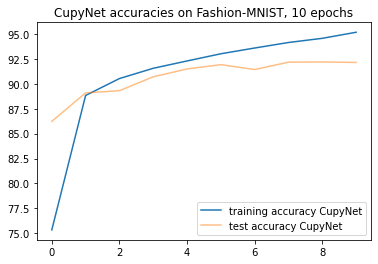

In [ ]:
plt.plot(range(len(train_accuracies)), train_accuracies, label="training accuracy CupyNet")
plt.plot(range(len(train_accuracies)), test_accuracies, label="test accuracy CupyNet", alpha=0.5)

plt.title(f"CupyNet accuracies on Fashion-MNIST, {num_epochs} epochs")
plt.legend()
plt.show()


<b>Great, the network is able to classify correctly the Fashion-MNIST in just 10 epochs!</b>
<br>
Now let's explain how the training worked.

### Backpropagation and surrogate gradient learning with SNNs

What we did earlier worked great, but we haven't talked about the learning process. We now know how neurons encode information and can be used in inference, but what about training?
<br>
As SNN use <i>spiking</i> neurons, how do we get a gradient to learn their parameters? And how to learn from the time steps simulation?

<a ref="https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_6.html">snntorch explaination of surrogate gradients</a>
<br>This page from snntorch, another library implementing SNNs, is great at explaining the surrogate gradient descent with SNNs. We will explain the key points bellow.

First thing to remark is that <b>SNNs can be regarded as RNNs</b>, with the hidden state being the membrane voltage, and the output a spike. Have a look back at the equations if needed.
<br>Following the RNN backward principle, you can <b>unfold the computational graph of the spiking neurons</b> through time.
Here is an illustration of that:<br>
<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial5/unrolled_2.png?raw=true" width="600"><br>
The benefit of an unrolled graph is that <b>it provides an explicit description of how computations are performed</b>. The process of unfolding illustrates the flow of information forward in time (from left to right) to compute outputs and losses, and backward in time to compute gradients.

<br>But <b>with SNNs the output is a spike</b>, produced by the Heaviside function, which is <b>not differenciable!</b>
<br>As the gradient will almost always be 0, or saturated if the $V_{membrane}$ is exactly $V_{threshold}$, you are unable to do the backward pass. This is known as the <b>dead neuron problem</b>.
<br><br>How to overcome the dead neuron problem?

The answer seems simple once you know it: in the forward pass you keep the Heaviside function with spikes, but also store the membrane potential to compute surrogate gradient during the backward pass:
<br><br>
Forward Pass:
- Determine $S$ using the shifted Heaviside function
- Store $V_{mem}$ for later use during the backward pass

Backward Pass
- Pass $V_{mem}$ into the surrogate gradient to calculate the derivative term

This essentialy smoothes the Heaviside function using a surrogate gradient, such as a sigmoid. Here is a great illustration:

<img src="https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial6/surrogate.png?raw=true" width="600">

<font color="carmin">You should get to the deep residual part in about 40 minutes to finish this notebook in one hour!</font>
<br>So you can skip this part or read it quickly if you spent more than 30 or 40 minutes to get here, and read it later if you want 😉

### Visualization of the first layers — bonus

Let's got back to the CupyNet and have a look at the firts layers

In [ ]:
net = CupyNet(T=4)
net.load_state_dict(torch.load(cupynet_cpt_dir, map_location=torch.device('cpu')))
net = net.to(DEVICE)

<b>The first spike neurons layer</b> (SN) neuron.MultiStepIFNode and the layers before it, a convolution and a batchnorm, <b>can be regarded as an auto-encoder</b> with learnable parameters.
<br>Here is a visualization:


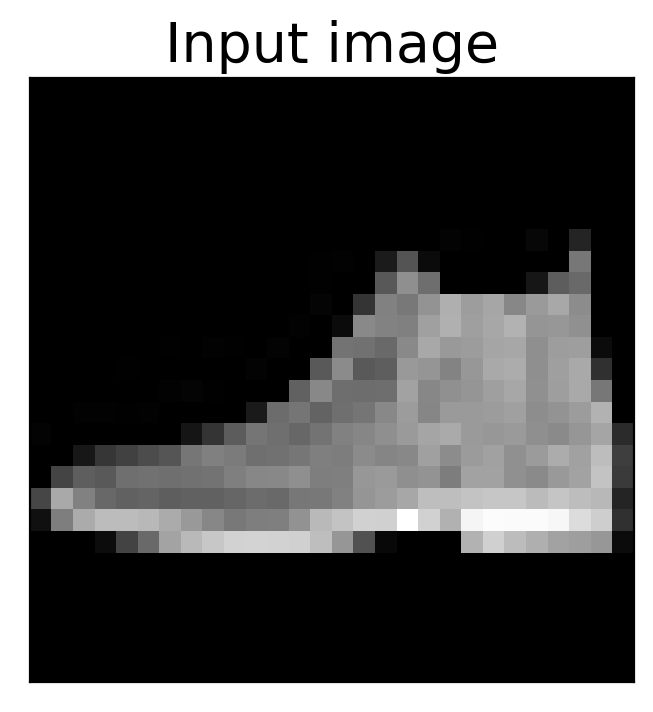

<Figure size 900x600 with 0 Axes>

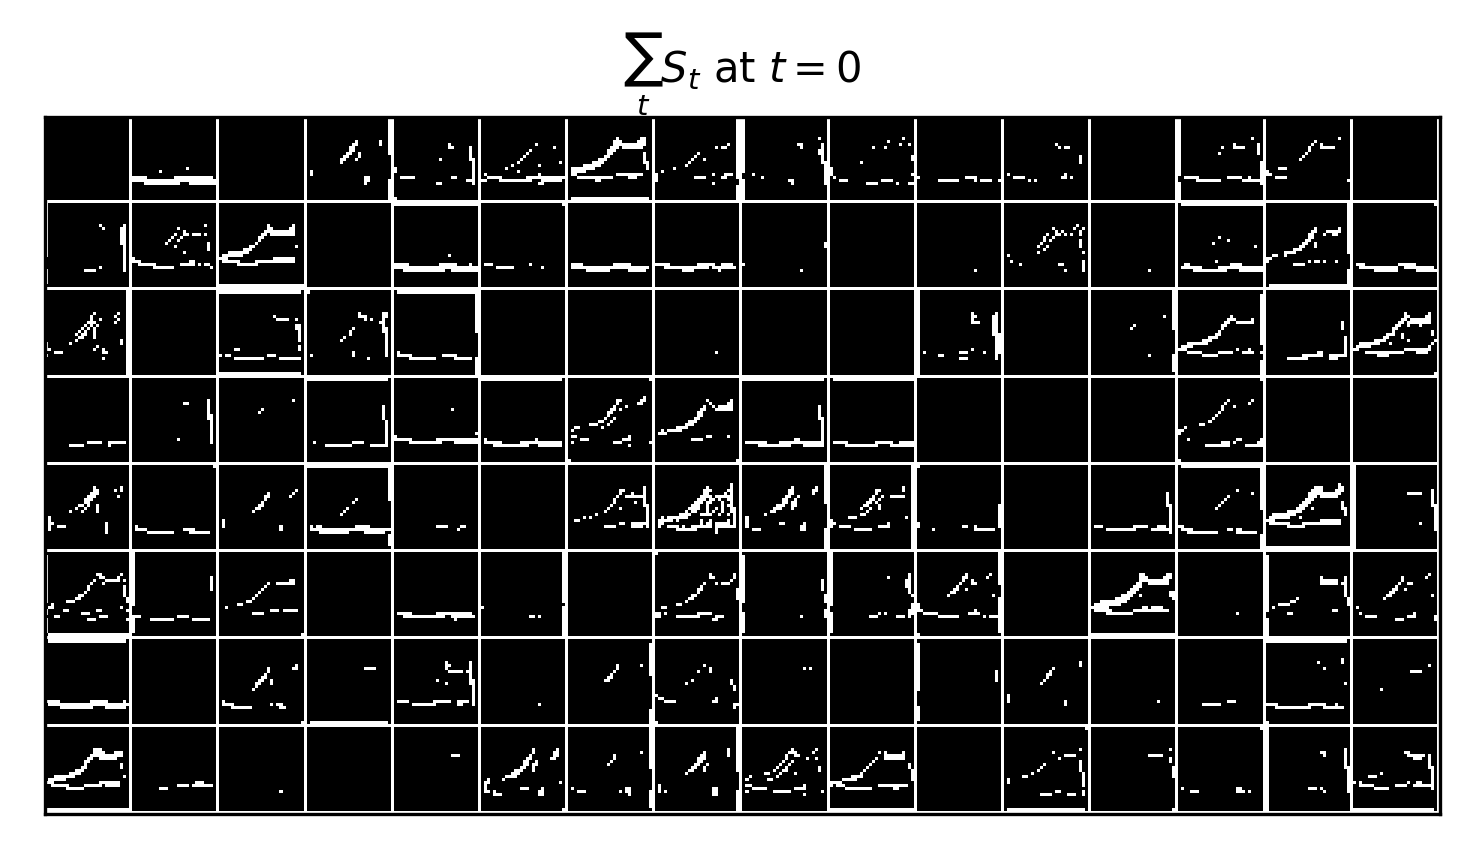

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

<Figure size 900x600 with 0 Axes>

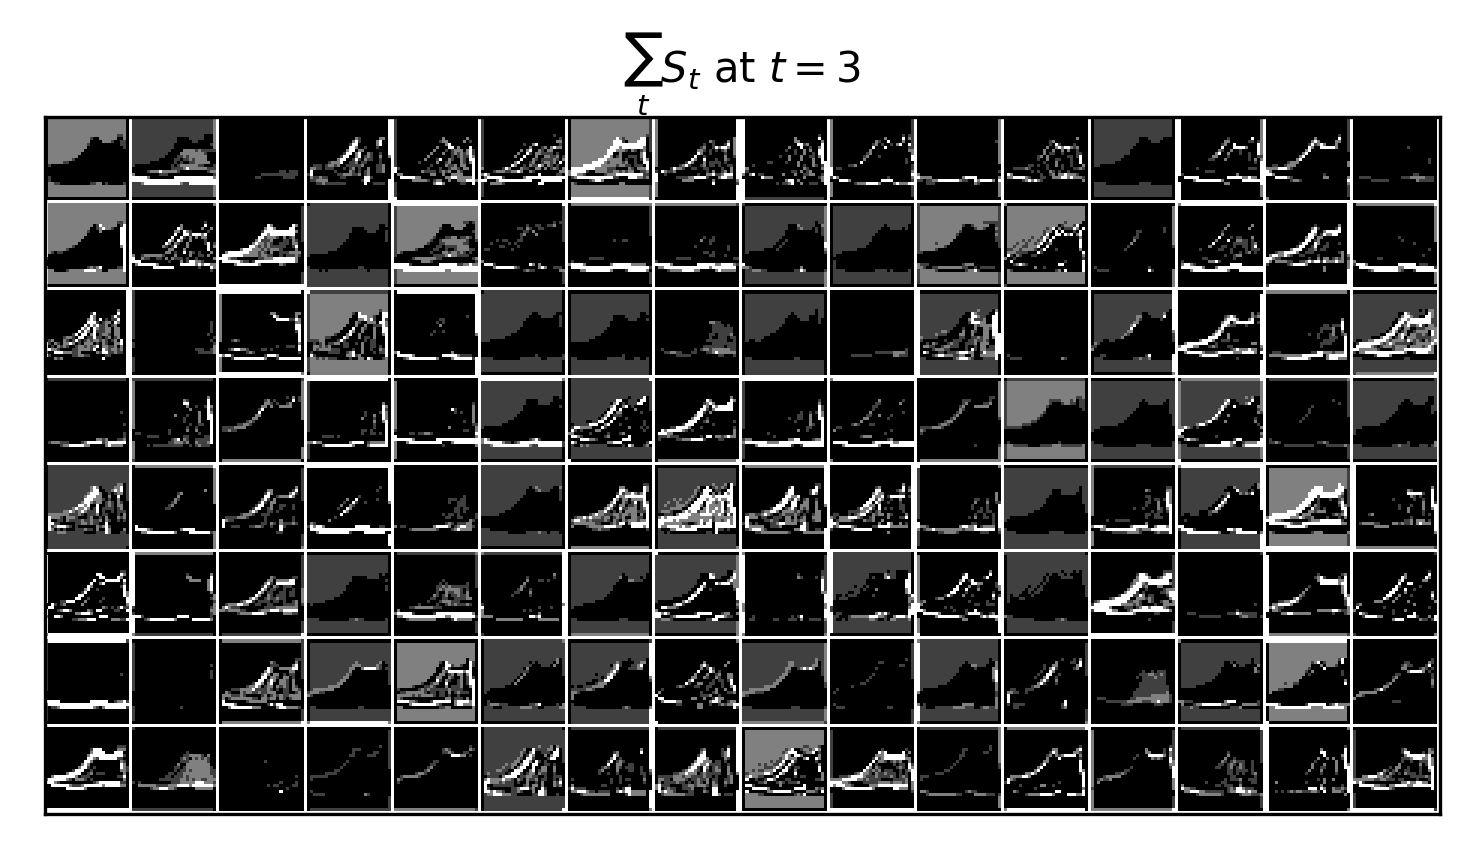

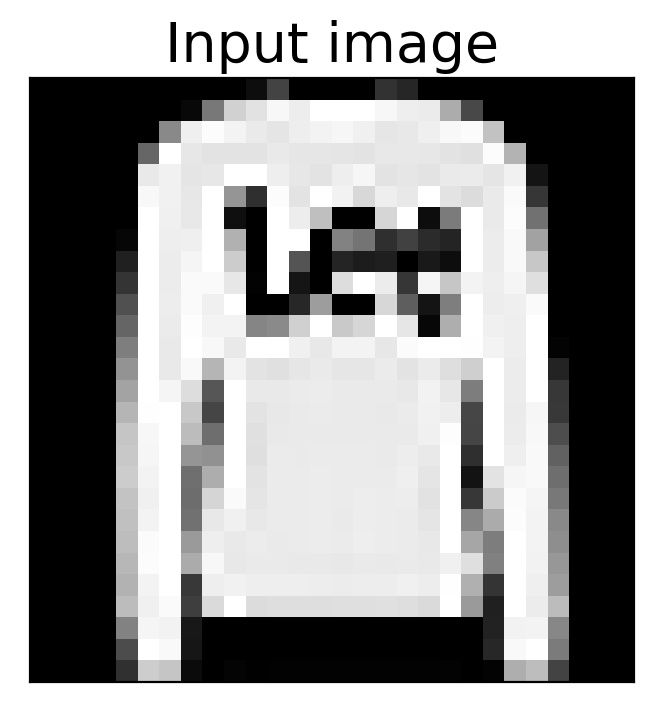

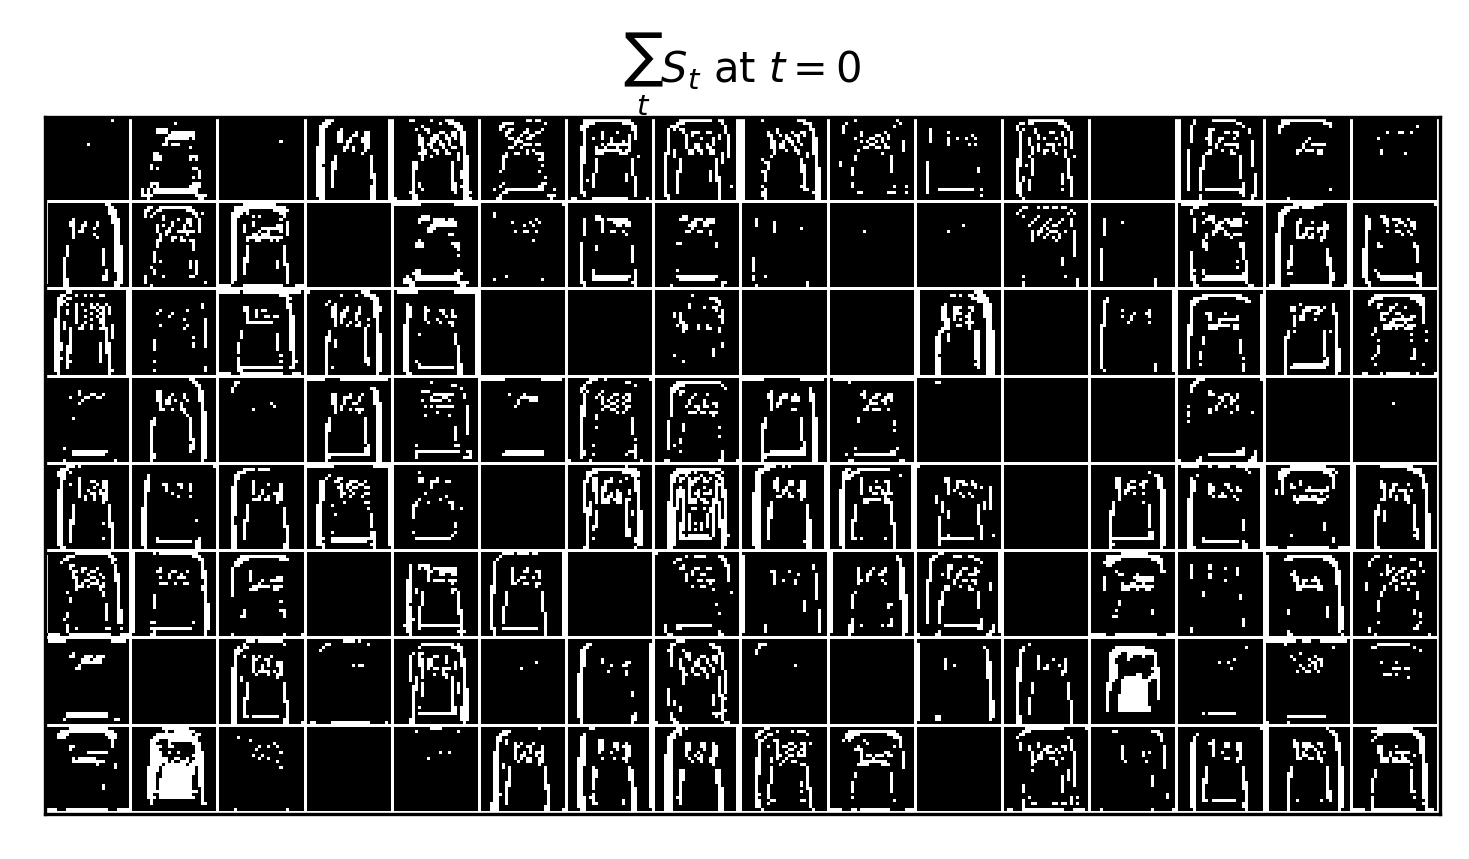

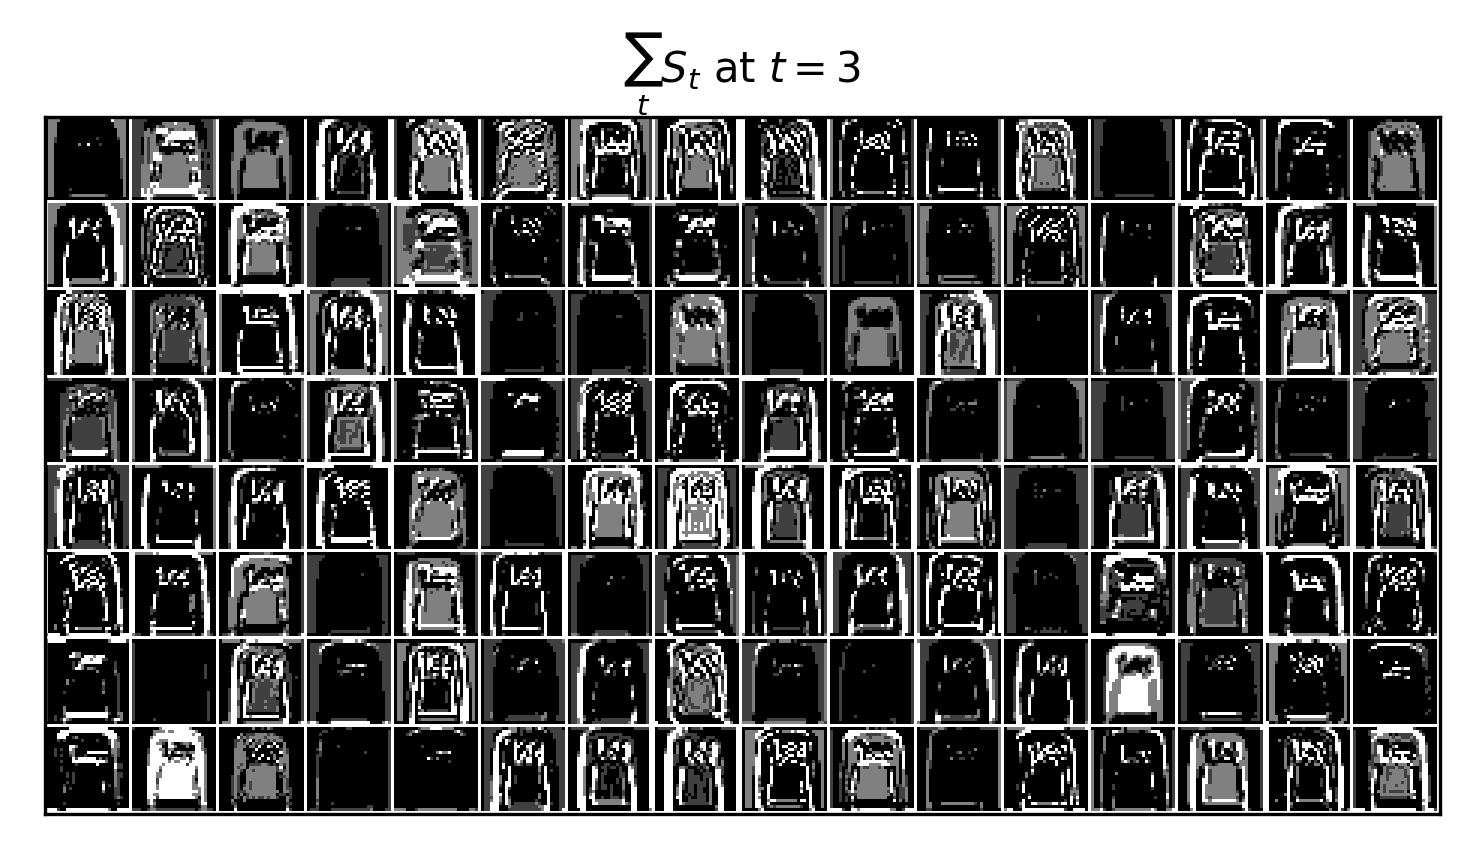

In [ ]:
# get the first layrs of the network
encoder = nn.Sequential(
    net.static_conv,
    net.conv[0]
)

encoder.to(DEVICE)
encoder.eval()

test_loader_fashion_one_batch = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

# we will use this to make a gif of the outputs over the simulation steps
plots = []
os.makedirs(Path("gifs"), exist_ok=True)

with torch.no_grad():
    for idx, (img, label) in enumerate(test_loader_fashion_one_batch):

        # we have to reset the neurons membrane's potentials before each inference!
        # else it would keep information from the previous run.
        # You can comment this line and see what happens!
        functional.reset_net(encoder)

        fig = plt.figure(dpi=100)
        plt.imshow(img.squeeze().numpy(), cmap='gray')
        # Note that the size of the image input to the network is ``[1, 1, 28, 28]``, the 0th dimension is ``batch``, and the first dimension is ``channel``
        # therefore, when calling ``imshow``, first use ``squeeze()`` to change the size to ``[28, 28]``
        plt.title('Input image', fontsize=20)
        plt.xticks([])
        plt.yticks([])
        plt.show()

        out_spikes = 0
        for t in range(net.T):
            one_out_spike = encoder(img.to(DEVICE)).squeeze()
            out_spikes += one_out_spike
            # the size of encoder(img) is ``[1, 128, 28, 28]``，the same use ``squeeze()`` transform size to ``[128, 28, 28]``

            if idx==0:
                fig, _ = visualizing.plot_2d_spiking_feature_map(one_out_spike.cpu(), 8, 16, 1, None, dpi=150)
                fig.savefig(f"./gifs/plot_{t}.png")
                plt.clf()

            if t == 0 or t == net.T - 1:
                out_spikes_c = out_spikes.clone()
                
                if t == net.T - 1: 
                    # this line is here to take the average of the output layer over the simulation steps
                    # This is how the encoder encodes data.
                    out_spikes_c /= t+1

                visualizing.plot_2d_spiking_feature_map(out_spikes_c.cpu(), 8, 16, 1, None, dpi=150)
                plt.title('$\\sum_{t} S_{t}$ at $t = ' + str(t) + '$', fontsize=10)
                plt.show()
        if idx >= 1:
            break


The encoder does a pretty good job on both inputs!
<br>Let's see the encoder activation at each specific step of the simulation:

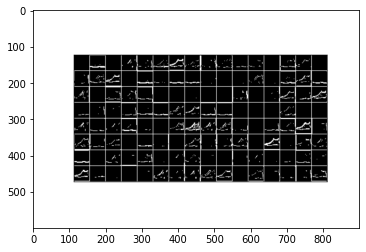

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def update(frame_number):
    image = plt.imread(f"./gifs/plot_{frame_number}.png")
    plt.imshow(image)

fig = plt.figure()
anim = animation.FuncAnimation(fig, update, frames=4, interval=500)

HTML(anim.to_jshtml())

# just look at the gif, discard the last image.


Here you can see how the first layers encodes the image. 
<br>The result you got earlier at the last step t=4 was the sum of all the images! We can get it back this way:

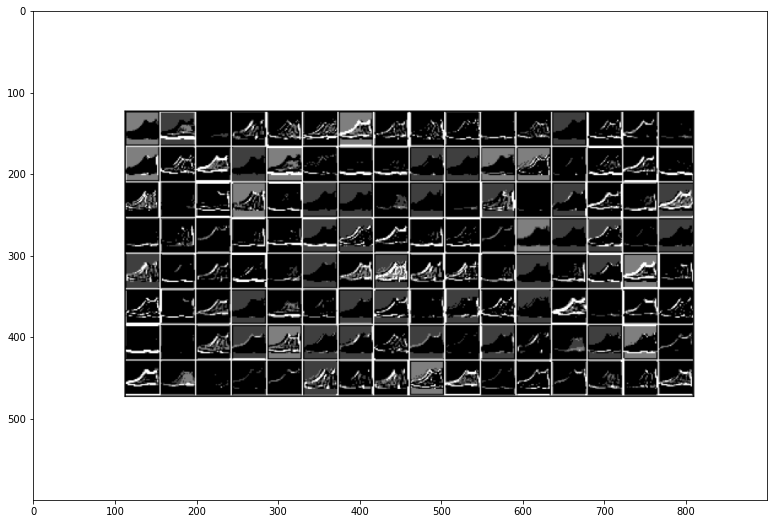

In [ ]:
summed_image = sum([plt.imread(f"./gifs/plot_{frame_number}.png") for frame_number in range(4)]) / 4
plt.figure(figsize=(15, 9))
plt.imshow(summed_image)

## Deep residual learning with SNNs

Great! We learned how spiking neurons work, how to train them and define a surrogate gradient for back-propagation, and make a small convolutional network with spiking layers!
<br><br>
Now let's dive into much deeper networks. 

### Explaination of ResNet and residual learning

<a href="https://ieeexplore.ieee.org/document/7780459">ResNet</a> (Residual Network) is well known as it introduced a new concept called residual learning, and won the 2015 ImageNet competition containing 1000 classes.
<br>
<b>ResNet addressed the vanishing gradient problem</b> in deep neural networks by introducing <b>skip connections</b>, or shortcut connections, that allow the gradients to bypass several layers. 
<br>This allows the network to train deeper architectures with 150+ layers, which was not possible before, and it lead to state-of-the-art results on image classification.

Let's illustrate a simple skip connection:
<br>
<img src="https://miro.medium.com/v2/resize:fit:1020/format:webp/1*TlcuN-PjLbXYSYQKqpTIzw.png">
<br>As you can see, a skip connection skips some layers and allows the information and the gradient to reach the deeper layers directly. This reduces the vanishing gradient problem. 
<br>When the dimension of the identify $x$ and $F(x)$ do not match, $x$ can be downsampled with convolution with a kernel size of 1.
<br><br>
Here is the ResNet architecture, that we will implement later with SNNs and 50 layers (ResNet-50):
<br>
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*9LqUp7XyEx1QNc6A.png">
<br>
As you can see the network is very deep, and skip connections allow the information and to gradient to bypass the different blocks!
<br><br>
ResNet-50 is implemented with a BottleNeck class, representing the blocks with shortcuts, and a ResNet class that brings all the layers together, plus the input and output layers.
<br>A classic ResNet implementation in pytorch can be found <a href="https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py">here</a>. Have a look at the BottleNeck class if you have the time.

### First implementation of ResNet-50 with SNNs, spiking-resnet

Now that we know ResNet architecture, we can implement it with SNNs, as we did before with the much smaller CupyNet.
<br><i>Let's hope residual learning still works with spiking neurons...</i>

<font color="crimson">Training this will take a lot of time and use 13+ GB of vram on the GPU. You do not need to run the cells bellow if you do not want to do the training by yourself. Key results are hardcoded.</font>
<br>If you want to do the training I advise you to reset your environment to clear the vram, and redo the importations at the top. 
<br>Also, as the trained model checkpoint is 200+ MB, it's not provided with this notebook.

ResNet won on the ImageNet dataset which is really huge, so for this notebook we'll use a much smaller dataset of 96*96 images, STL10.
<br>
If you want to do the training, run this to load the dataset.

#### Spiking ResNet-50 implementation

In [ ]:
# Define the data transform (normalization, augmentation to reduce overfitting)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(96),
    transforms.ToTensor(),
    # Normalize with mean, std of the train dataset
    transforms.Normalize([0.44671074, 0.43981016, 0.40664612], [0.26034108, 0.25657744, 0.27126727]) 
])

# we do not put the flips and rotations in the test transform! that's not what we want to check when running on the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.44671074, 0.43981016, 0.40664612], [0.26034108, 0.25657744, 0.27126727])
])

# Load the training and test datasets
train_dataset = datasets.STL10(root=data_folder, split='train', download=True, transform=transform_train)
test_dataset = datasets.STL10(root=data_folder, split='test', download=True, transform=transform_test)


Let's implement the BottleNeck with spiking layers and the residual!
<br><br>Code of spiking and SEW resnet bellow are adapted and simplified for easier comprehension from <a href="https://github.com/fangwei123456/spikingjelly/blob/0.0.0.0.12/spikingjelly/clock_driven/model/spiking_resnet.py">spikingjelly implementation</a>.

In [ ]:
class Spiking_Bottleneck(nn.Module):
    # The expansion factor is used to increase the number of output channels. 
    # Increasing the number of output channels allows the network to extract more 
    # features from the input, which can improve the accuracy of the model
    expansion = 4

    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super(Spiking_Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        # that's what differs from classical ResNET, there are our spiking neurons
        # replacing the ReLU.
        self.sn1 = neuron.MultiStepIFNode(backend=snn_backend)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.sn2 = neuron.MultiStepIFNode(backend=snn_backend)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.sn3 = neuron.MultiStepIFNode(backend=snn_backend)

        self.downsample = downsample

        self.stride = stride

        
    def forward(self, x):
        residual = x.clone()
        
        out = x

        # seq_to_ann_forward allows stateless ANN to handle the input 
        # that is sequential data coming from previous spiking layers
        out = seq_to_ann_forward(out, [self.conv1, self.batch_norm1])
        out = self.sn1(out)

        out = seq_to_ann_forward(out, [self.conv2, self.batch_norm2])
        out = self.sn2(out)
        
        out = seq_to_ann_forward(out, [self.conv3, self.batch_norm3])

        # downsample if needed (if the in_cannels in x do not match the out_channels*expansion)
        if self.downsample is not None:
            residual = seq_to_ann_forward(residual, self.downsample)

        # here we add the residual to the output
        #
        # as said before the residual is also called the "skip connexion". 
        # It's used to solve the vanishing gradient problem in deep networks.
        out += residual

        # Then we apply the SNN layer, as the ResNet applies the ReLU here
        out = self.sn3(out)

        return out

Okay, now we can implement the ResNet class with spiking layers.

In [ ]:
class Spiking_ResNet(nn.Module):
    T = 4 # number of simulation steps

    def __init__(self, ResBlock, layer_list = [3, 4, 6, 3], num_classes=10, num_channels=3):
        super(Spiking_ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)

        # In ResNet this is a ReLU
        # as before we replace this with a spiking layer
        self.sn1 = neuron.MultiStepIFNode(backend=snn_backend)

        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x: torch.Tensor):
        x_seq = None

        # reshape X to fit the simulation steps. 
        # It's exactly what we did in CupyNet just before the first spiking layer,
        # as we also have a static image in input
        if x.dim() == 5:
            # x.shape = [T, N, C, H, W]
            x_seq = seq_to_ann_forward(x, [self.conv1, self.batch_norm1])
        else:
            assert self.T is not None, 'When x.shape is [N, C, H, W], self.T can not be None.'
            # x.shape = [N, C, H, W]
            x = self.conv1(x)
            x = self.batch_norm1(x)
            x.unsqueeze_(0)
            x_seq = x.repeat(self.T, 1, 1, 1, 1)

        x_seq = self.sn1(x_seq)
        x_seq = seq_to_ann_forward(x_seq, self.maxpool)

        x_seq = self.layer1(x_seq)
        x_seq = self.layer2(x_seq)
        x_seq = self.layer3(x_seq)
        x_seq = self.layer4(x_seq)
        
        x_seq = seq_to_ann_forward(x_seq, self.avgpool)

        x_seq = torch.flatten(x_seq, 2)

        x_seq = seq_to_ann_forward(x_seq, self.fc)

        # as in CupyNet we return the mean of x_seq over the time steps.
        return x_seq.mean(dim=0)
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride, bias = False),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, downsample=downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for _ in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)


Now let's train the algorithm. You can just have a look at the script if you do not want to train.

In [ ]:
resnet = Spiking_ResNet(Spiking_Bottleneck, num_classes=10, num_channels=3)
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.1)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=64)

out_dir = Path("checkpoints/spiking_resnet/")

if not out_dir.is_dir():
    os.makedirs(out_dir, exist_ok=True)

max_test_acc = 0
num_classes = 10

train_accuracies = []
test_accuracies = []

resnet.train()

batch_size = 64 # using 32 or less might help if Cuda is out of memory
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
num_epochs = 40

for epoch in range(num_epochs):
    train_acc = 0
    train_samples = 0

    resnet.train()

    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = resnet(images)

        loss = criterion(outputs, F.one_hot(labels, num_classes).float())
        loss.backward()
        optimizer.step()

        train_acc += (outputs.argmax(1) == labels).float().sum().item()
        train_samples += labels.numel()

        # do not forget to reset the net. This will reset the spiking neurons temporal data!
        functional.reset_net(resnet)

    train_acc /= train_samples
    train_accuracies.append(train_acc * 100)

    lr_scheduler.step()

    resnet.eval()
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for images, labels in test_data_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            label_onehot = F.one_hot(labels, 10).float()

            outputs = resnet(images)

            test_acc += (outputs.argmax(1) == labels).float().sum().item()
            test_samples += labels.numel()

            # reset membrane potentials
            functional.reset_net(resnet)

    test_acc /= test_samples
    test_accuracies.append(100 * test_acc)

    save_max = False
    if test_accuracies[-1] > max_test_acc:
        max_test_acc = test_accuracies[-1]
        save_max = True

    checkpoint = {
        'resnet': resnet.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
        'max_test_acc': max_test_acc
    }

    if save_max:
        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

    torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_latest.pth'))


    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Train accuracy: {100 * train_acc:.2f}% Test accuracy: {100 * test_acc:.2f}%')


#### Results with Spiking ResNet-50

Here is what we get after training the network. If you do the training by yourself just replace the accuracy variables!

In [ ]:
%config InlineBackend.figure_format = 'retina'
# makes the plots more pretty

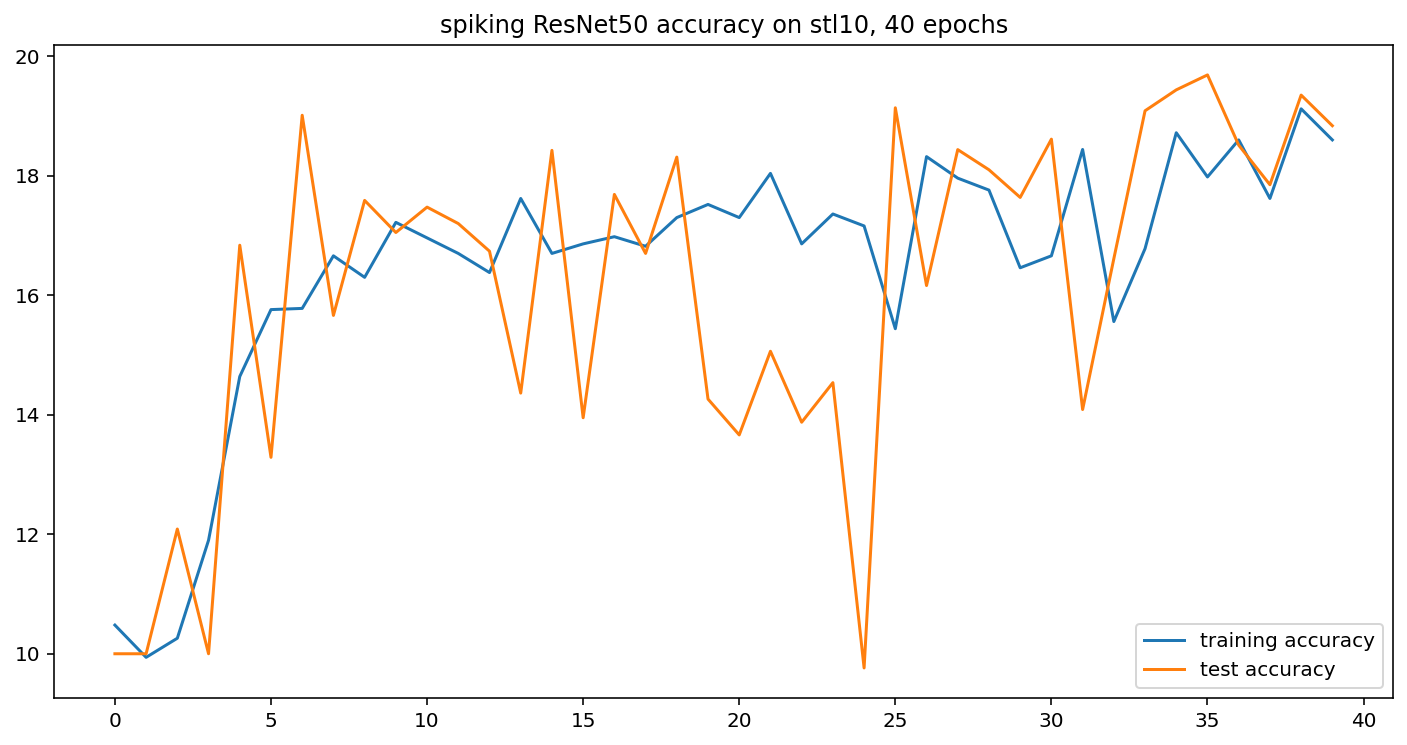

In [ ]:
spiking_resnet_train_acc = [10.48, 9.94, 10.26, 11.899999999999999, 14.64, 15.76, 15.78, 16.66, 16.3, 17.22, 16.96, 16.7, 16.38, 17.62, 16.7, 16.86, 16.98, 16.82, 17.299999999999997, 17.52, 17.299999999999997, 18.04, 16.86, 17.36, 17.16, 15.440000000000001, 18.32, 17.96, 17.76, 16.46, 16.66, 18.44, 15.559999999999999, 16.78, 18.72, 17.98, 18.6, 17.62, 19.12, 18.6]
spiking_resnet_test_acc = [10.0, 10.0, 12.0875, 10.0, 16.8375, 13.2875, 19.0125, 15.662499999999998, 17.5875, 17.05, 17.474999999999998, 17.2, 16.7375, 14.3625, 18.425, 13.950000000000001, 17.6875, 16.7, 18.3125, 14.2625, 13.6625, 15.0625, 13.875000000000002, 14.5375, 9.762500000000001, 19.1375, 16.162499999999998, 18.4375, 18.099999999999998, 17.6375, 18.6125, 14.0875, 16.6125, 19.0875, 19.4375, 19.6875, 18.512500000000003, 17.849999999999998, 19.35, 18.8375]

plt.figure(figsize=(12,6))
plt.plot(range(len(spiking_resnet_train_acc)), spiking_resnet_train_acc, label="training accuracy")
plt.plot(range(len(spiking_resnet_train_acc)), spiking_resnet_test_acc, label="test accuracy")
plt.title(f"spiking ResNet50 accuracy on stl10, 40 epochs")
plt.legend()
plt.show()

<b>The results are pretty bad...</b> A ResNet trains better than that!
<br><b>What went wrong? Residual learning does not work with SNNs?</b>

In the original ResNet paper cited above, it is noted that if the added layers implement the identity mapping, <b>a deeper model should have training error no greater than its shallower counterpart</b>. 
<br>But it is not the case with Spiking ResNet, where Spiking ResNet-18 acheives better results than Spiking ResNet-50. It is discribed in <a href="https://arxiv.org/abs/2102.04159">the paper this notebook aims to explain</a>, cited at the very top:
<br><img src="https://github.com/arthurlaquieze/deep-residual-learning-SNN/blob/main/img/spiking-resnet-results.png?raw=true" width="400">
<br><br>
As explained in this same paper, Spiking ResNet suffers from the vanishing/exploding gradient problem, as the non-linearity of spiking neurons is ignored: you've seen how we just replaced ReLU layers by spiking layers in the code above.
<br><br>
So, what can we do to address this issue?

### A solution proposed by our paper: Spike-Element-Wise Resnet — SEW-Resnet

Our first implementation of ResNet-50 with spiking layers is not a success. 
<br>A solution is proposed in the paper we're interested in, "Deep Residual Learning in Spiking Neural Networks.", let's explain it and implement it!

The proposed solution is to change the residual block identity mapping to overcome the vanishing gradient.
<br>In this solution, the spiking layer is moved <b>before</b> the identity mapping, and the identity mapping is done with an element-wise function, $g$, taking two spikes tensors as inputs.
<br>Here is the illustration of this change in a BottleNeck with downsample:
<br><img src="https://github.com/arthurlaquieze/deep-residual-learning-SNN/blob/main/img/downsample-blocks-SEW-vs-Spiking.png?raw=true">
<br>Without downsample the Conv, BN, and SN are not needed, as the block input is already spikes. 
<br><br>An easy way to understand this function $g$ is to have a look at its python implementation in SpikingJelly:


In [ ]:
def sew_function(x: torch.Tensor, y: torch.Tensor, cnf:str):
    if cnf == 'ADD':
        # for each element of x and y:
        # outputs 2 if both inputs are 1 / spikes,
        # 1 if there is only one spike in input
        # 0 / no spike else
        return x + y
    elif cnf == 'AND':
        # 1 if both inputs are 1, else 0
        return x * y
    elif cnf == 'IAND':
        # 1 if x's element is 1 and y's is 0
        return x * (1. - y)
    else:
        raise NotImplementedError


Okay, let's implement that and replace our Spiking-BottleNeck with the SEW-BottleNeck!
<br>As the paper finds the best results with the <i>ADD</i> mapping, that's what we will use.

#### SEW-ResNet BottleNeck implementation

In [ ]:
class SEW_Bottleneck(nn.Module):
    # The expansion factor is used to increase the number of output channels. 
    # Increasing the number of output channels allows the network to extract more features from the input, which can improve the accuracy of the model
    expansion = 4

    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super(SEW_Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        # as before, that's what differs from classical ResNET
        self.sn1 = neuron.MultiStepIFNode(backend=snn_backend)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.sn2 = neuron.MultiStepIFNode(backend=snn_backend)

        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.sn3 = neuron.MultiStepIFNode(backend=snn_backend)

        self.downsample = downsample

        # Step added to the identify mapping downsample for the SEW resnet
        # after the downsample convolution and batchnorm
        if downsample is not None:
          self.downsample_sn = neuron.MultiStepIFNode(backend=snn_backend)

        self.stride = stride

        # ADD gives the best results in the paper.
        self.cnf = "ADD"
        
    def forward(self, x):
        residual = x.clone()
        
        out = x

        out = seq_to_ann_forward(out, [self.conv1, self.batch_norm1])
        out = self.sn1(out)

        out = seq_to_ann_forward(out, [self.conv2, self.batch_norm2])
        out = self.sn2(out)
        
        out = seq_to_ann_forward(out, [self.conv3, self.batch_norm3])

        # do this before adding the residual, as seen in the illustration above
        out = self.sn3(out)

        # downsample if needed (if the in_cannels in x do not match the out_channels*expansion)
        #
        # downsample_sn acts as the ReLU, but it is before the addition of the residual here! 
        if self.downsample is not None:
            residual = self.downsample_sn(seq_to_ann_forward(residual, self.downsample))

        # that's the replacement for the identity mapping out+=residual we did 
        # with the Spiking-Resnet and what's done in the classic ResNET
        out = sew_function(residual, out, self.cnf)
        
        return out

Okay, not a lot changed! Let's do the training and see how it improves the results.

In [ ]:
try: 
  del resnet
except NameError:
  pass
torch.cuda.empty_cache()
print("allocated memory ",torch.cuda.memory_allocated())
torch.cuda.memory_cached()

In [ ]:
resnet = Spiking_ResNet(SEW_Bottleneck, num_classes=10, num_channels=3)
resnet = resnet.to(DEVICE)

criterion = nn.CrossEntropyLoss()
# we can start with a lower learning rate than with Spiking Resnet
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=64)

out_dir = Path("checkpoints/sew_resnet/")
if not out_dir.is_dir():
    os.makedirs(out_dir, exist_ok=True)

max_test_acc = 0
num_classes = 10

train_accuracies_sew = []
test_accuracies_sew = []

resnet.train()

batch_size = 64
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training is exactly the same as before

In [ ]:
num_epochs = 40

for epoch in range(num_epochs):
    train_acc = 0
    train_samples = 0

    resnet.train()

    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = resnet(images)

        loss = criterion(outputs, F.one_hot(labels, num_classes).float())
        loss.backward()
        optimizer.step()

        train_acc += (outputs.argmax(1) == labels).float().sum().item()
        train_samples += labels.numel()

        # do not forget to reset the net. This will reset the spiking neurons temporal data!
        functional.reset_net(resnet)

    train_acc /= train_samples
    train_accuracies_sew.append(train_acc * 100)

    lr_scheduler.step()

    resnet.eval()
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        for images, labels in test_data_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            label_onehot = F.one_hot(labels, 10).float()

            outputs = resnet(images)

            test_acc += (outputs.argmax(1) == labels).float().sum().item()
            test_samples += labels.numel()

            # reset membrane potentials
            functional.reset_net(resnet)

    test_acc /= test_samples
    test_accuracies_sew.append(100 * test_acc)

    save_max = False
    if test_accuracies_sew[-1] > max_test_acc:
        max_test_acc = test_accuracies_sew[-1]
        save_max = True

    checkpoint = {
        'resnet': resnet.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
        'max_test_acc': max_test_acc
    }

    if save_max:
        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

    torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_latest.pth'))


    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, Train accuracy: {100 * train_acc:.2f}% Test accuracy: {100 * test_acc:.2f}%')


#### SEW-Resnet-50 results and improvements over Spiking-ResNet-50

Let's see if we've improved our results!

again, if you trained by yourself you can replace the variables with the good ones, the results are hardcoded bellow:

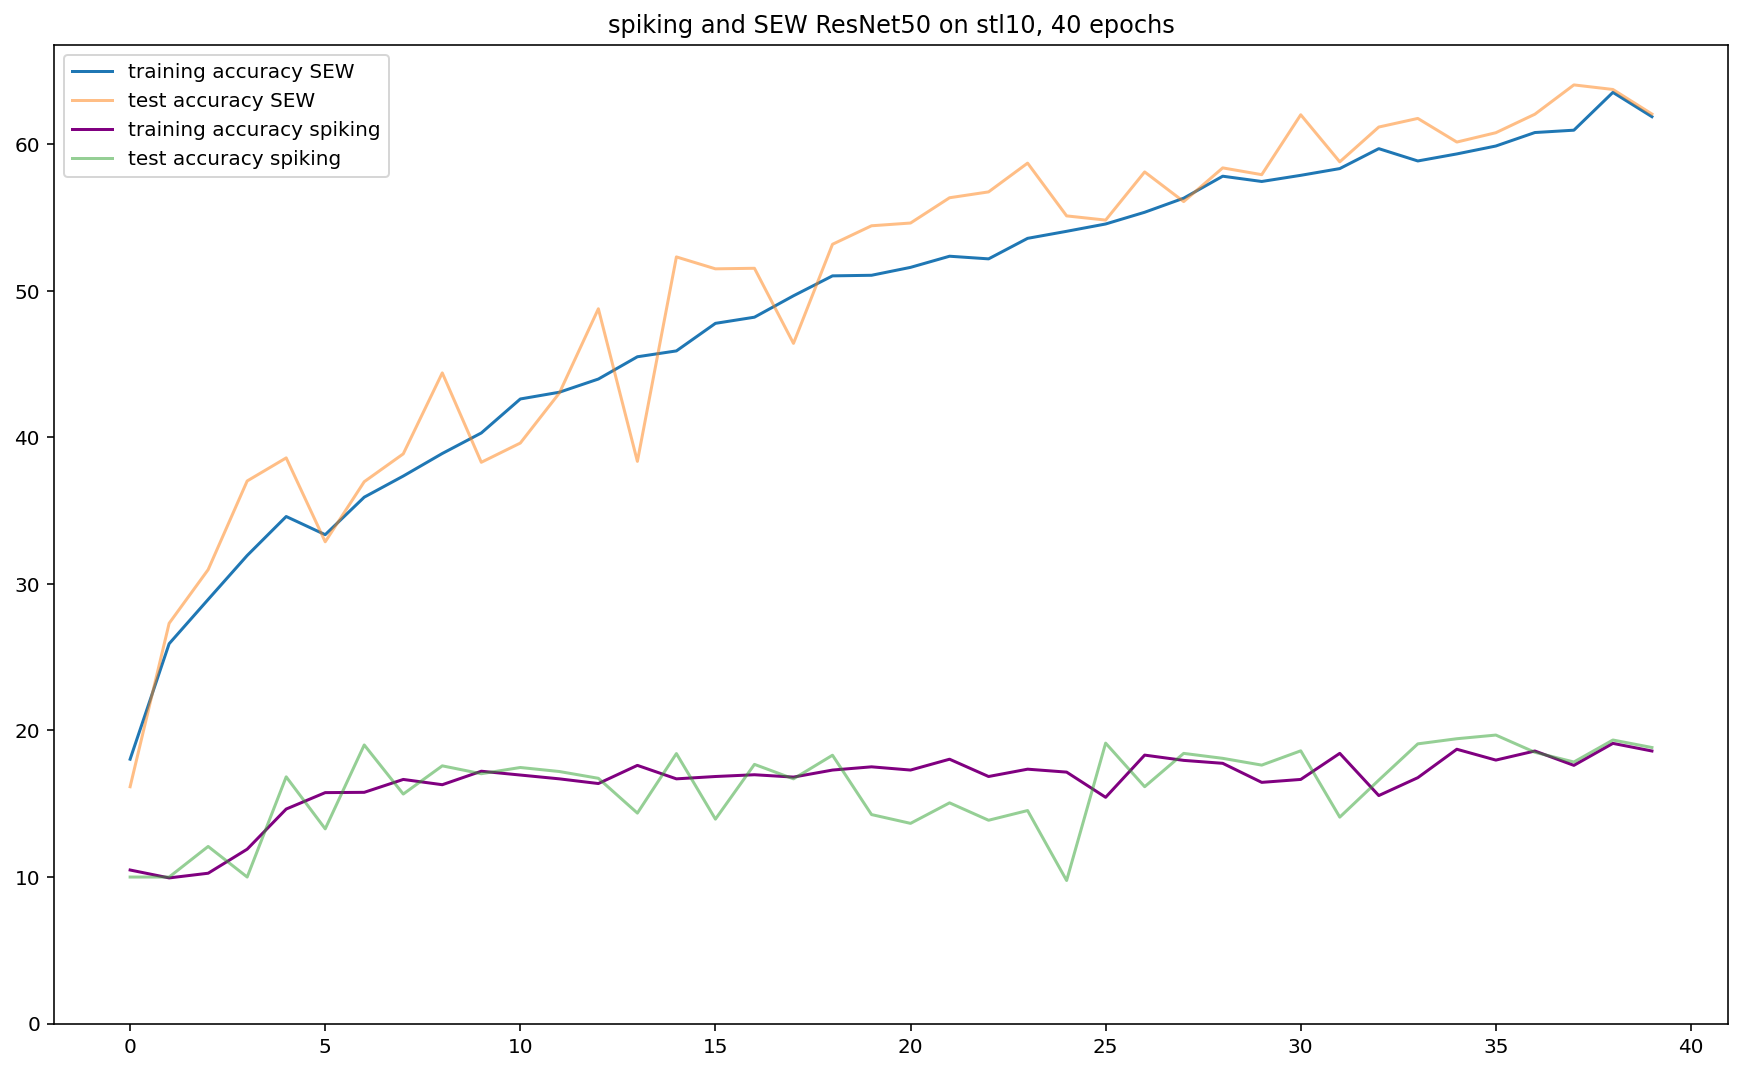

In [ ]:
sew_resnet_train_accuracies = [18.04, 25.919999999999998, 28.939999999999998, 31.94, 34.599999999999994, 33.36, 35.92, 37.36, 38.9, 40.300000000000004, 42.620000000000005, 43.08, 43.980000000000004, 45.5, 45.9, 47.78, 48.199999999999996, 49.66, 51.019999999999996, 51.06, 51.6, 52.35999999999999, 52.18000000000001, 53.580000000000005, 54.059999999999995, 54.559999999999995, 55.36, 56.32, 57.82000000000001, 57.46, 57.879999999999995, 58.34, 59.699999999999996, 58.86, 59.34, 59.88, 60.8, 60.96, 63.54, 61.88]
sew_resnet_test_accuracies = [16.162499999999998, 27.3125, 30.975, 37.025000000000006, 38.6, 32.875, 36.975, 38.875, 44.4, 38.3, 39.6125, 43.025000000000006, 48.775, 38.3625, 52.31249999999999, 51.5, 51.5375, 46.4125, 53.175, 54.43750000000001, 54.625, 56.35, 56.75, 58.7125, 55.1125, 54.825, 58.1125, 56.0875, 58.3875, 57.925000000000004, 62.0125, 58.8, 61.175000000000004, 61.762499999999996, 60.150000000000006, 60.78750000000001, 62.050000000000004, 64.05, 63.737500000000004, 62.0625]
spiking_resnet_train_acc = [10.48, 9.94, 10.26, 11.899999999999999, 14.64, 15.76, 15.78, 16.66, 16.3, 17.22, 16.96, 16.7, 16.38, 17.62, 16.7, 16.86, 16.98, 16.82, 17.299999999999997, 17.52, 17.299999999999997, 18.04, 16.86, 17.36, 17.16, 15.440000000000001, 18.32, 17.96, 17.76, 16.46, 16.66, 18.44, 15.559999999999999, 16.78, 18.72, 17.98, 18.6, 17.62, 19.12, 18.6]
spiking_resnet_test_acc = [10.0, 10.0, 12.0875, 10.0, 16.8375, 13.2875, 19.0125, 15.662499999999998, 17.5875, 17.05, 17.474999999999998, 17.2, 16.7375, 14.3625, 18.425, 13.950000000000001, 17.6875, 16.7, 18.3125, 14.2625, 13.6625, 15.0625, 13.875000000000002, 14.5375, 9.762500000000001, 19.1375, 16.162499999999998, 18.4375, 18.099999999999998, 17.6375, 18.6125, 14.0875, 16.6125, 19.0875, 19.4375, 19.6875, 18.512500000000003, 17.849999999999998, 19.35, 18.8375]


fig = plt.figure(figsize=(15, 9))
plt.plot(range(len(sew_resnet_train_accuracies)), sew_resnet_train_accuracies, label="training accuracy SEW")
plt.plot(range(len(sew_resnet_train_accuracies)), sew_resnet_test_accuracies, label="test accuracy SEW", alpha=0.5)


plt.plot(range(len(spiking_resnet_train_acc)), spiking_resnet_train_acc, label="training accuracy spiking", c='purple')
plt.plot(range(len(spiking_resnet_train_acc)), spiking_resnet_test_acc, label="test accuracy spiking", alpha=0.5)

plt.title(f"spiking and SEW ResNet50 on stl10, 40 epochs")
plt.legend()
plt.ylim(0)
plt.show()

Awesome!
<br>Thanks to the sew_function and the changing of the identity mapping, we've managed to make our model way better by overcoming the vanishing gradient problem of the Spiking-ResNet.
<br><br>The results shown in that paper will hopefully allow to train very deep SNNs!
<br>Here is their results on the ImageNet dataset and with different ResNet depth:
<img src="https://github.com/arthurlaquieze/deep-residual-learning-SNN/blob/main/img/SEW-vs-Spiking-different-depth.png?raw=true">

Thanks for reading this notebook, I hope you've learned many things!
<br>I also want to thank the authors of this paper and of the spikingjelly library for their work.

<img src="https://github.com/arthurlaquieze/deep-residual-learning-SNN/blob/main/img/happy_beaver.png?raw=true">